In [1]:
%cd ..

c:\Users\hp zbook\Documents\GitHub\Geasture_ESP


In [2]:
import pandas as pd

# Load your Excel file
data = pd.read_csv(r"data\preprocessed_sensor_data.csv")

print(data)

        accel_x   accel_y   accel_z    gyro_x    gyro_y    gyro_z     label
0      0.138310 -1.517150 -1.126000 -0.869678  0.130410  0.020820      down
1      0.266782 -1.539707 -1.048848  0.728805  1.316047  1.147585      down
2      0.186696 -1.602174 -1.013578 -0.724362  0.262147  1.147585      down
3      0.186696 -1.499798 -1.187722 -0.869678  0.525622  0.471526      down
4      0.300151 -1.569205 -1.017987 -1.450945 -0.791752  0.696879      down
...         ...       ...       ...       ...       ...       ...       ...
11901 -0.195382 -0.030095  1.532445  0.002221 -0.660015  0.696879  striaght
11902 -0.192045 -0.037036  1.539058  0.292855 -0.264803  0.696879  striaght
11903 -0.192045 -0.030095  1.528037  0.002221 -0.791752  0.696879  striaght
11904 -0.177029 -0.033565  1.534650  0.002221 -0.528278  0.696879  striaght
11905 -0.217072 -0.026625  1.523628  0.147538 -0.001328  0.696879  striaght

[11906 rows x 7 columns]


In [6]:
# Extract features and labels
features = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']
X_raw = data[features]
y_raw = data['label']


# Recreate the DataFrame with labels
normalized_data = pd.DataFrame(X_raw, columns=features)
normalized_data['label'] = y_raw.values

In [7]:
import numpy as np

def create_sequences(data, features, window_size=100, stride=50):
    sequences = []
    labels = []
    for label in data['label'].unique():
        class_data = data[data['label'] == label]
        class_values = class_data[features].values
        for start in range(0, len(class_values) - window_size + 1, stride):
            end = start + window_size
            seq = class_values[start:end]
            sequences.append(seq)
            labels.append(label)
    return np.array(sequences), np.array(labels)


In [8]:
# Apply function
X_seq, y_seq = create_sequences(normalized_data, features)
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_seq)
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [9]:
print(y_encoded)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3]


In [10]:
# Shuffle the data
X_seq, y_encoded = shuffle(X_seq, y_encoded, random_state=42)

In [11]:
# Split into 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_encoded, test_size=0.2, random_state=42)
# Optional if you want to be sure:
y_train = y_train.astype('int32')
y_test = y_test.astype('int32')

In [25]:
from tensorflow.keras.layers import Layer, Input, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow.keras.backend as K
from tensorflow.keras.utils import register_keras_serializable

# Custom Attention Layer
@register_keras_serializable()
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight', 
                                 shape=(input_shape[-1], 1),
                                 initializer='normal')
        self.b = self.add_weight(name='att_bias',
                                 shape=(input_shape[1], 1),
                                 initializer='zeros')
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        e = K.tanh(K.dot(inputs, self.W) + self.b)         # (batch_size, seq_len, 1)
        a = K.softmax(e, axis=1)                           # (batch_size, seq_len, 1)
        output = inputs * a                                # (batch_size, seq_len, features)
        return K.sum(output, axis=1)                       # (batch_size, features)

    def get_config(self):
        base_config = super(AttentionLayer, self).get_config()
        return base_config

In [26]:
# Model configuration
seq_length = X_train.shape[1]
num_features = X_train.shape[2]
num_classes = len(label_encoder.classes_)

# Build the model
model = Sequential([
    Input(shape=(seq_length, num_features)),
    Bidirectional(LSTM(128, return_sequences=True)),
    AttentionLayer(),                        # Outputs (batch_size, features)
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax') # Outputs (batch_size, num_classes)
])

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Callbacks
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint("best_model.h5", save_best_only=True)
]

# Show summary
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 100, 256)       │       138,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer_1               │ (None, 256)            │           356 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 146,985 (574.16 KB)

 Trainable params: 146,985 (574.16 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=32, callbacks=callbacks)

Epoch 1/30


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.4224 - loss: 1.4669

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 189ms/step - accuracy: 0.4467 - loss: 1.4504 - val_accuracy: 1.0000 - val_loss: 0.9655
Epoch 2/30
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9269 - loss: 0.9067

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.9385 - loss: 0.8675 - val_accuracy: 1.0000 - val_loss: 0.4443
Epoch 3/30
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 1.0000 - loss: 0.3940

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 1.0000 - loss: 0.3775 - val_accuracy: 1.0000 - val_loss: 0.1553
Epoch 4/30
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.1404

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 1.0000 - loss: 0.1319 - val_accuracy: 1.0000 - val_loss: 0.0383
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 0.0311

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 1.0000 - loss: 0.0306 - val_accuracy: 1.0000 - val_loss: 0.0107
Epoch 6/30
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 0.0117

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 1.0000 - loss: 0.0110 - val_accuracy: 1.0000 - val_loss: 0.0042
Epoch 7/30
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 0.0045

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 1.0000 - loss: 0.0043 - val_accuracy: 1.0000 - val_loss: 0.0022
Epoch 8/30
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 0.0025

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 1.0000 - loss: 0.0024 - val_accuracy: 1.0000 - val_loss: 0.0015
Epoch 9/30
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 0.0016

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 10/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 1.0000 - loss: 0.0012

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 9.3980e-04
Epoch 11/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 9.3514e-04

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 1.0000 - loss: 9.4517e-04 - val_accuracy: 1.0000 - val_loss: 8.1273e-04
Epoch 12/30
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 0.0010

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 1.0000 - loss: 9.9067e-04 - val_accuracy: 1.0000 - val_loss: 7.2093e-04
Epoch 13/30
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 1.0000 - loss: 9.1877e-04

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 1.0000 - loss: 9.0800e-04 - val_accuracy: 1.0000 - val_loss: 6.5062e-04
Epoch 14/30
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 8.3491e-04

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 1.0000 - loss: 8.2681e-04 - val_accuracy: 1.0000 - val_loss: 5.9452e-04
Epoch 15/30
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 7.0494e-04

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 1.0000 - loss: 7.0329e-04 - val_accuracy: 1.0000 - val_loss: 5.4785e-04
Epoch 16/30
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 1.0000 - loss: 7.3386e-04

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 1.0000 - loss: 7.1948e-04 - val_accuracy: 1.0000 - val_loss: 5.0751e-04
Epoch 17/30
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 1.0000 - loss: 6.2696e-04

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 1.0000 - loss: 6.2305e-04 - val_accuracy: 1.0000 - val_loss: 4.7241e-04
Epoch 18/30
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 1.0000 - loss: 5.5911e-04

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 1.0000 - loss: 5.6182e-04 - val_accuracy: 1.0000 - val_loss: 4.4156e-04
Epoch 19/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 5.4766e-04

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 1.0000 - loss: 5.4586e-04 - val_accuracy: 1.0000 - val_loss: 4.1358e-04
Epoch 20/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 4.8964e-04

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 4.9068e-04 - val_accuracy: 1.0000 - val_loss: 3.8824e-04
Epoch 21/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 1.0000 - loss: 4.4808e-04

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 4.4850e-04 - val_accuracy: 1.0000 - val_loss: 3.6506e-04
Epoch 22/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 4.7995e-04

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 4.7681e-04 - val_accuracy: 1.0000 - val_loss: 3.4353e-04
Epoch 23/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 4.1753e-04

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 4.1637e-04 - val_accuracy: 1.0000 - val_loss: 3.2412e-04
Epoch 24/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 4.2274e-04

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 4.2018e-04 - val_accuracy: 1.0000 - val_loss: 3.0652e-04
Epoch 25/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 3.9479e-04

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 1.0000 - loss: 3.9391e-04 - val_accuracy: 1.0000 - val_loss: 2.9015e-04
Epoch 26/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 3.2780e-04

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 1.0000 - loss: 3.2937e-04 - val_accuracy: 1.0000 - val_loss: 2.7539e-04
Epoch 27/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 3.4741e-04

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 3.4700e-04 - val_accuracy: 1.0000 - val_loss: 2.6166e-04
Epoch 28/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 3.4763e-04

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 1.0000 - loss: 3.4559e-04 - val_accuracy: 1.0000 - val_loss: 2.4860e-04
Epoch 29/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 1.0000 - loss: 3.4470e-04

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 1.0000 - loss: 3.4213e-04 - val_accuracy: 1.0000 - val_loss: 2.3623e-04
Epoch 30/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 3.0860e-04

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 3.0576e-04 - val_accuracy: 1.0000 - val_loss: 2.2492e-04


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 381ms/step

Classification Report:
              precision    recall  f1-score   support

        down       1.00      1.00      1.00        12
        left       1.00      1.00      1.00         8
       right       1.00      1.00      1.00         7
    striaght       1.00      1.00      1.00        11
          up       1.00      1.00      1.00         9

    accuracy                           1.00        47
   macro avg       1.00      1.00      1.00        47
weighted avg       1.00      1.00      1.00        47



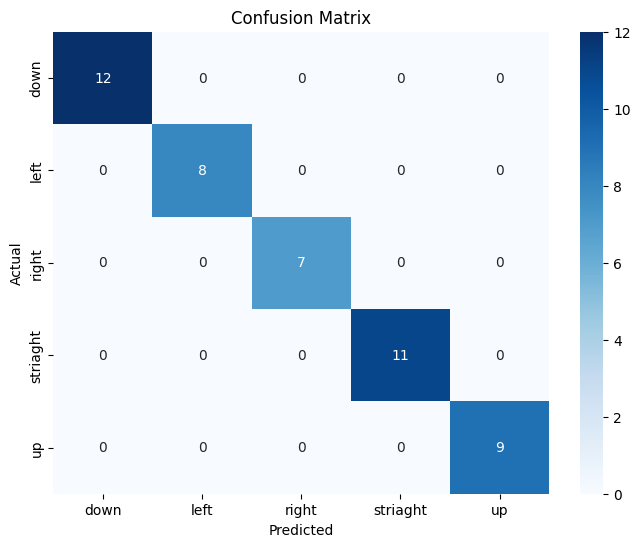

In [28]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict classes
y_pred = np.argmax(model.predict(X_test), axis=1)

# Get all possible encoded labels (e.g., [0, 1, 2, 3, 4])
all_labels = np.arange(len(label_encoder.classes_))

# Print classification report with all labels, even if some are missing in y_test
print("\nClassification Report:")
print(classification_report(
    y_test,
    y_pred,
    labels=all_labels,
    target_names=label_encoder.classes_,
    zero_division=0  # Avoid divide-by-zero if a class is missing
))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=all_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
import joblib

# Save model in the new recommended format
model.save("models/motion_model.keras")

# Save the scaler and label encoder
joblib.dump(label_encoder, "models/label_encoder.pkl")


['models/label_encoder.pkl']

In [ ]:
import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
import os

# === Load model, scaler, and label encoder ===
model = load_model("models/motion_model.keras", custom_objects={'AttentionLayer': AttentionLayer})
scaler = joblib.load("models/scaler.pkl")
label_encoder = joblib.load("models/label_encoder.pkl")

# === Function to clean and preprocess one CSV file ===
def infer(filepath, features, window_size=100, stride=50):
    df = pd.read_csv(filepath)
    
    # Clean column names
    df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
    
    # Drop NaNs
    df = df.dropna()
    
    # Select only features
    df_features = df[features]

    # Scale
    df_scaled = scaler.transform(df_features)

    # Repackage into DataFrame
    df_scaled = pd.DataFrame(df_scaled, columns=features)

    # Create sequences
    sequences = []
    for start in range(0, len(df_scaled) - window_size + 1, stride):
        end = start + window_size
        seq = df_scaled.iloc[start:end].values
        sequences.append(seq)
    
    return np.array(sequences)

# === Define your feature columns ===
features = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']

# === Choose a file to predict ===
file_to_predict = "data\humans\sensor_data S aysel.csv"  # <-- change this path to test other files

# === Preprocess ===
X_input = infer(file_to_predict, features)

# === Predict ===
predictions = model.predict(X_input)
predicted_classes = np.argmax(predictions, axis=1)
decoded_labels = label_encoder.inverse_transform(predicted_classes)

# === Output the results ===
from collections import Counter
most_common = Counter(decoded_labels).most_common(1)[0][0]
print(f"\nPredicted movement: {most_common}")


c:\Users\hp zbook\anaconda3\envs\grad_ESP\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 14 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step

Predicted movement: striaght
